In [380]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import quantstats as qs

In [381]:
# 讀取資料
vix_df = pd.read_csv("VIX_History.csv", parse_dates=['Date'])
txf_df  = pd.read_csv('TXF_R1_1min_data_combined.csv', parse_dates=['datetime'])
# df_0050 = pd.read_excel("0050.xlsx")

In [382]:
# 篩選日盤時間
txf_df = txf_df[
    (txf_df['datetime'].dt.time >= pd.to_datetime('08:45').time()) &
    (txf_df['datetime'].dt.time <= pd.to_datetime('13:45').time())
]
txf_df = txf_df[(txf_df['datetime'] >= '2009-01-01') & (txf_df['datetime'] <= '2025-06-30')]
# 新增一欄日期方便 groupby（只保留年月日）
txf_df['date'] = txf_df['datetime'].dt.date

# 聚合當日日盤資料
txf_df = txf_df.groupby('date').agg(
    Open=('Open', 'first'),
    High=('High', 'max'),
    Low=('Low', 'min'),
    Close=('Close', 'last')
).reset_index()

# 若你想把 date 轉回 datetime
txf_df['datetime'] = pd.to_datetime(txf_df['date'])


In [383]:
# 將VIX時間與台灣時間對齊
vix_df = vix_df.rename(columns={'Close': 'VIX'}).fillna(0)
vix_df = vix_df.rename(columns={'Date': 'datetime'}).fillna(0)
vix_df = vix_df[['datetime', 'VIX']]
vix_df['datetime'] = pd.to_datetime(vix_df['datetime']) + pd.Timedelta(days=1)

# 將資料標準化
txf_df['datetime'] = pd.to_datetime(txf_df['datetime']).dt.normalize()
vix_df['datetime'] = pd.to_datetime(vix_df['datetime']).dt.normalize()

# 合併資料
txf_df = pd.merge(txf_df, vix_df, on='datetime', how='left')
txf_df = txf_df.sort_values('datetime')
txf_df.fillna(method='ffill', inplace=True)
txf_df.at[0, 'VIX'] = 39.19

# 紀錄市場報酬
market_df = txf_df.copy()

C:\Users\herby\AppData\Local\Temp\ipykernel_5136\4014616098.py:14: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



In [384]:
# 技術指標計算
txf_df['High10'] = txf_df['High'].rolling(10).max()
txf_df['Low10'] = txf_df['Low'].rolling(10).min()
txf_df['%R'] = (txf_df['High10'] - txf_df['Close']) / (txf_df['High10'] - txf_df['Low10']) * -100

# txf_df['VIX_10d_max'] = txf_df['VIX'].rolling(3).max()
# txf_df['VIX_10d_new_high'] = txf_df['VIX'] == txf_df['VIX_10d_max']
# txf_df.drop(columns=['VIX_10d_max'], inplace=True)

In [385]:
txf_df['PositionRaw'] = 0
txf_df['EntrySignal'] = 0
txf_df['ExitSignal'] = 0
txf_df['PnL'] = 0.0          # 單日損益（不含成本）
txf_df['Cost'] = 0.0         # 單日交易成本
txf_df['NetPnL'] = 0.0       # 單日淨損益（含成本）
txf_df['Equity'] = 1_000_000 # 資金曲線
txf_df['TradeReturn'] = 0.0  # 每日報酬率
txf_df['TradingDate'] = 0

position = 0
fee_per_trade = 600     # 固定金額，進出各扣一次
capital = 1_000_000     # 初始資金
contract_size = 200     # 大台一點價值

pending_entry = False
pending_exit = False

for i in range(len(txf_df)):
    cost_today = 0.0
    pnl = 0.0

    if i > 0:
        prev_row = txf_df.iloc[i - 1]
        row = txf_df.iloc[i]
        point_diff = row['Close'] - prev_row['Close']

        # 先計算當日損益（基於進入當日的持倉位置）
        if position > 0:
            pnl = point_diff * contract_size

        # 處理前一天的 pending 進出場（在當日執行）
        if pending_exit:
            position = 0
            cost_today += fee_per_trade  # 出場扣費
            pending_exit = False

        if pending_entry:
            position = 1
            cost_today += fee_per_trade  # 進場扣費
            pending_entry = False

        # 計算淨損益並更新資本
        net_pnl = pnl - cost_today
        trade_return = net_pnl / capital if capital > 0 else 0
        capital += net_pnl

        # 存入 DataFrame
        txf_df.at[i, 'PnL'] = pnl
        txf_df.at[i, 'Cost'] = cost_today
        txf_df.at[i, 'NetPnL'] = net_pnl
        txf_df.at[i, 'TradeReturn'] = trade_return
        txf_df.at[i, 'Equity'] = capital

    # 記錄當日結束時的持倉位置
    txf_df.at[i, 'PositionRaw'] = position

    # 檢查當日訊號，為下一天設定 pending（如果不是最後一天）
    if i < len(txf_df) - 1:
        row = txf_df.iloc[i]

        # 進出場訊號（訊號產生，但延遲到下一天執行）
        long_signal = (row['%R'] < -95) and (row['VIX'] > 18)
        exit_signal = (row['%R'] > -0.5)

        # 出場訊號（包含原邏輯的 or long_signal，以避免重複進場）
        if position > 0 and (exit_signal or long_signal):
            pending_exit = True
            txf_df.at[i, 'ExitSignal'] = 1  # 標記訊號日（實際執行在 i+1）

        # 進場訊號（無論是否持倉，如果有新訊號且需先出場，則在出場後進場）
        if long_signal:
            pending_entry = True
            txf_df.at[i, 'EntrySignal'] = 1  # 標記訊號日（實際執行在 i+1）

# 標記交易區間
in_trade = False
for i in range(len(txf_df)):
    if txf_df.at[i, 'PositionRaw'] == 1 and not in_trade:
        in_trade = True
    if in_trade:
        txf_df.at[i, 'TradingDate'] = 1
    if in_trade and txf_df.at[i, 'PositionRaw'] == 0 and (i > 0 and txf_df.at[i - 1, 'PositionRaw'] == 1):
        in_trade = False

In [386]:
# # 參數最佳化
# def backtest(txf_df, entry_th, exit_th, vix_th=18):
#     txf_df = txf_df.copy()
#     txf_df['PositionRaw'] = 0
#     txf_df['EntrySignal'] = 0
#     txf_df['ExitSignal'] = 0
#     txf_df['PnL'] = 0.0
#     txf_df['Cost'] = 0.0
#     txf_df['NetPnL'] = 0.0
#     txf_df['Equity'] = 1_000_000
#     txf_df['TradeReturn'] = 0.0
#     txf_df['TradingDate'] = 0

#     position = 0
#     fee_per_trade = 600
#     capital = 1_000_000
#     contract_size = 200

#     pending_entry = False
#     pending_exit = False

#     for i in range(len(txf_df)):
#         cost_today = 0.0
#         pnl = 0.0

#         if i > 0:
#             prev_row = txf_df.iloc[i - 1]
#             row = txf_df.iloc[i]
#             point_diff = row['Close'] - prev_row['Close']

#             if position > 0:
#                 pnl = point_diff * contract_size

#             if pending_exit:
#                 position = 0
#                 cost_today += fee_per_trade
#                 pending_exit = False

#             if pending_entry:
#                 position = 1
#                 cost_today += fee_per_trade
#                 pending_entry = False

#             net_pnl = pnl - cost_today
#             trade_return = net_pnl / capital if capital > 0 else 0
#             capital += net_pnl

#             txf_df.at[i, 'PnL'] = pnl
#             txf_df.at[i, 'Cost'] = cost_today
#             txf_df.at[i, 'NetPnL'] = net_pnl
#             txf_df.at[i, 'TradeReturn'] = trade_return
#             txf_df.at[i, 'Equity'] = capital

#         txf_df.at[i, 'PositionRaw'] = position

#         if i < len(txf_df) - 1:
#             row = txf_df.iloc[i]
#             long_signal = (row['%R'] < entry_th) and (row['VIX'] > vix_th)
#             exit_signal = (row['%R'] > exit_th)

#             if position > 0 and (exit_signal or long_signal):
#                 pending_exit = True
#                 txf_df.at[i, 'ExitSignal'] = 1

#             if long_signal:
#                 pending_entry = True
#                 txf_df.at[i, 'EntrySignal'] = 1

#     in_trade = False
#     for i in range(len(txf_df)):
#         if txf_df.at[i, 'PositionRaw'] == 1 and not in_trade:
#             in_trade = True
#         if in_trade:
#             txf_df.at[i, 'TradingDate'] = 1
#         if in_trade and txf_df.at[i, 'PositionRaw'] == 0 and (i > 0 and txf_df.at[i - 1, 'PositionRaw'] == 1):
#             in_trade = False

#     returns = txf_df['TradeReturn']
#     sharpe = np.mean(returns) / np.std(returns) * np.sqrt(252) if len(returns) > 1 and np.std(returns) != 0 else 0.0
#     return sharpe, txf_df['Equity'].iloc[-1]

# # 最佳化參數範圍（針對 %R 進場和出場門檻）
# entry_th_range = np.arange(-100, -60, 5)  # %R 進場門檻範圍
# exit_th_range = np.arange(-5, 0, 0.5)    # %R 出場門檻範圍

# # 收集結果
# results = []
# for entry_th in entry_th_range:
#     for exit_th in exit_th_range:
#         sharpe, final_equity = backtest(txf_df, entry_th, exit_th, vix_th=18)
#         results.append({'entry_th': entry_th, 'exit_th': exit_th, 'sharpe': sharpe, 'final_equity': final_equity})

# results_df = pd.DataFrame(results)

# # 繪製參數高原（熱圖）
# pivot_sharpe = results_df.pivot(index='entry_th', columns='exit_th', values='sharpe')
# fig, ax = plt.subplots(figsize=(12, 8))
# im = ax.imshow(pivot_sharpe.values, cmap='viridis', aspect='auto')

# ax.set_xticks(np.arange(len(exit_th_range)))
# ax.set_yticks(np.arange(len(entry_th_range)))
# ax.set_xticklabels([f'{x:.1f}' for x in exit_th_range], rotation=45)
# ax.set_yticklabels([f'{x:.1f}' for x in entry_th_range])
# plt.colorbar(im, label='Sharpe Ratio')
# ax.set_xlabel('Exit %R Threshold')
# ax.set_ylabel('Entry %R Threshold')
# ax.set_title('Parameter Plateau: Sharpe Ratio Heatmap (VIX fixed at >18)')

# plt.show()

# # 印出最佳參數
# best_idx = results_df['sharpe'].idxmax()
# best_entry = results_df.loc[best_idx, 'entry_th']
# best_exit = results_df.loc[best_idx, 'exit_th']
# best_sharpe = results_df.loc[best_idx, 'sharpe']
# print(f'Best Parameters: Entry %R < {best_entry}, Exit %R > {best_exit}, Sharpe: {best_sharpe:.2f}')

In [ ]:
txf_df

Performance Metrics:
Sharpe Ratio: 0.9259
Max Drawdown: 0.2567
Annualized Return: 0.1057
Win Rate: 1.0000
Profit Factor: inf
Total Trades: 17


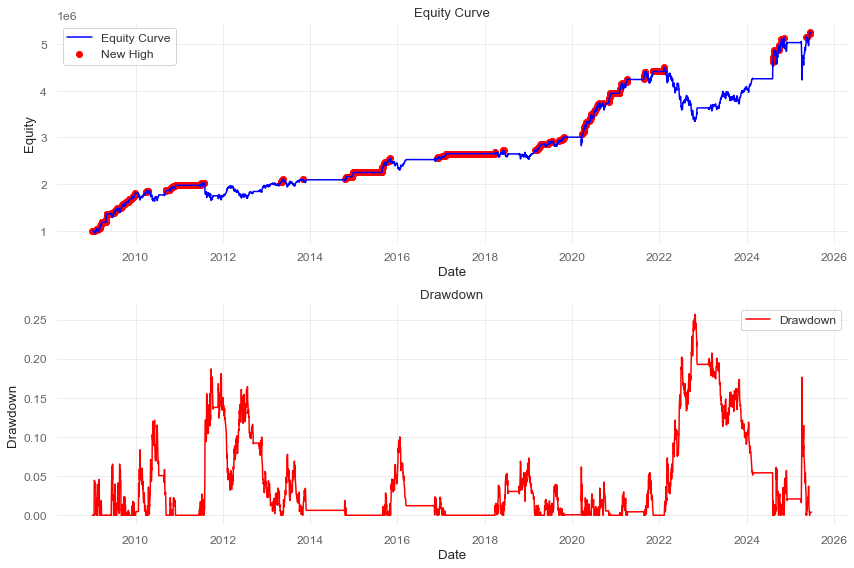

In [400]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Backtest code with metrics calculation
def run_backtest(txf_df):
    txf_df = txf_df.copy()  # Avoid modifying original DataFrame
    txf_df['PositionRaw'] = 0
    txf_df['EntrySignal'] = 0
    txf_df['ExitSignal'] = 0
    txf_df['PnL'] = 0.0
    txf_df['Cost'] = 0.0
    txf_df['NetPnL'] = 0.0
    txf_df['Equity'] = 1_000_000
    txf_df['TradeReturn'] = 0.0
    txf_df['TradingDate'] = 0

    position = 0
    fee_per_trade = 600
    capital = 1_000_000
    contract_size = 200

    pending_entry = False
    pending_exit = False

    for i in range(len(txf_df)):
        cost_today = 0.0
        pnl = 0.0

        if i > 0:
            prev_row = txf_df.iloc[i - 1]
            row = txf_df.iloc[i]
            point_diff = row['Close'] - prev_row['Close']

            if position > 0:
                pnl = point_diff * contract_size

            if pending_exit:
                position = 0
                cost_today += fee_per_trade
                pending_exit = False

            if pending_entry:
                position = 1
                cost_today += fee_per_trade
                pending_entry = False

            net_pnl = pnl - cost_today
            trade_return = net_pnl / capital if capital > 0 else 0
            capital += net_pnl

            txf_df.at[i, 'PnL'] = pnl
            txf_df.at[i, 'Cost'] = cost_today
            txf_df.at[i, 'NetPnL'] = net_pnl
            txf_df.at[i, 'TradeReturn'] = trade_return
            txf_df.at[i, 'Equity'] = capital

        txf_df.at[i, 'PositionRaw'] = position

        if i < len(txf_df) - 1:
            row = txf_df.iloc[i]
            long_signal = (row['%R'] < -95) and (row['VIX'] > 18)
            exit_signal = (row['%R'] > -0.5)

            if position > 0 and (exit_signal or long_signal):
                pending_exit = True
                txf_df.at[i, 'ExitSignal'] = 1

            if long_signal:
                pending_entry = True
                txf_df.at[i, 'EntrySignal'] = 1

    in_trade = False
    for i in range(len(txf_df)):
        if txf_df.at[i, 'PositionRaw'] == 1 and not in_trade:
            in_trade = True
        if in_trade:
            txf_df.at[i, 'TradingDate'] = 1
        if in_trade and txf_df.at[i, 'PositionRaw'] == 0 and (i > 0 and txf_df.at[i - 1, 'PositionRaw'] == 1):
            in_trade = False

    return txf_df

# Calculate performance metrics
def calculate_metrics(txf_df, initial_capital=1_000_000):
    # Ensure datetime is in correct format
    txf_df['datetime'] = pd.to_datetime(txf_df['datetime'])
    
    # 1. Sharpe Ratio (Annualized)
    returns = txf_df['TradeReturn']
    sharpe = np.mean(returns) / np.std(returns) * np.sqrt(252) if len(returns) > 1 and np.std(returns) != 0 else 0.0

    # 2. Maximum Drawdown (MDD)
    equity = txf_df['Equity']
    rolling_max = equity.cummax()
    drawdowns = (rolling_max - equity) / rolling_max
    mdd = drawdowns.max()

    # 3. Annualized Return (CAGR)
    n_years = (txf_df['datetime'].iloc[-1] - txf_df['datetime'].iloc[0]).days / 365.25
    final_equity = equity.iloc[-1]
    cagr = (final_equity / initial_capital) ** (1 / n_years) - 1 if n_years > 0 else 0.0

    # 4. Calculate trades
    trades = []
    entry_price = None
    entry_idx = None
    for i in range(1, len(txf_df)):
        if txf_df['EntrySignal'].iloc[i] == 1 and txf_df['PositionRaw'].iloc[i] == 1:
            entry_price = txf_df['Close'].iloc[i]
            entry_idx = i
        elif txf_df['ExitSignal'].iloc[i] == 1 and txf_df['PositionRaw'].iloc[i-1] == 1 and entry_price is not None:
            exit_price = txf_df['Close'].iloc[i]
            trade_pnl = (exit_price - entry_price) * contract_size - 2 * fee_per_trade
            trades.append({'entry_idx': entry_idx, 'exit_idx': i, 'pnl': trade_pnl})
            entry_price = None

    trades_df = pd.DataFrame(trades)

    # 5. Win Rate
    win_trades = len(trades_df[trades_df['pnl'] > 0])
    total_trades = len(trades_df)
    win_rate = win_trades / total_trades if total_trades > 0 else 0.0

    # 6. Profit Factor
    gross_profits = trades_df[trades_df['pnl'] > 0]['pnl'].sum()
    gross_losses = abs(trades_df[trades_df['pnl'] < 0]['pnl'].sum())
    profit_factor = gross_profits / gross_losses if gross_losses > 0 else float('inf')

    return {
        'Sharpe Ratio': sharpe,
        'Max Drawdown': mdd,
        'Annualized Return': cagr,
        'Win Rate': win_rate,
        'Profit Factor': profit_factor,
        'Total Trades': total_trades
    }, equity, drawdowns

# Run backtest and calculate metrics
txf_df = run_backtest(txf_df)
metrics, equity, drawdowns = calculate_metrics(txf_df)

# Print metrics
print("Performance Metrics:")
for key, value in metrics.items():
    print(f"{key}: {value:.4f}" if key != 'Total Trades' else f"{key}: {value}")

# Visualize Equity Curve and Drawdowns
plt.figure(figsize=(12, 8))

# Equity Curve
# 計算累積最大值（創新高）
txf_df['Equity_High'] = txf_df['Equity'].cummax()
new_high_idx = txf_df[txf_df['Equity'] == txf_df['Equity_High']].index
plt.subplot(2, 1, 1)
plt.plot(txf_df['datetime'], equity, label='Equity Curve', color='blue')
plt.scatter(txf_df.loc[new_high_idx, 'datetime'], 
            txf_df.loc[new_high_idx, 'Equity'], 
            color='red', marker='o', label='New High')
plt.title('Equity Curve')
plt.xlabel('Date')
plt.ylabel('Equity')
plt.grid(True)
plt.legend()

# Drawdowns
plt.subplot(2, 1, 2)
plt.plot(txf_df['datetime'], drawdowns, label='Drawdown', color='red')
plt.title('Drawdown')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [388]:
# 報酬可視化
txf_df['date'] = pd.to_datetime(txf_df['date'])
txf_df['Year'] = txf_df['date'].dt.year
txf_df['Month'] = txf_df['date'].dt.month
txf_df['Day'] = txf_df['date'].dt.day


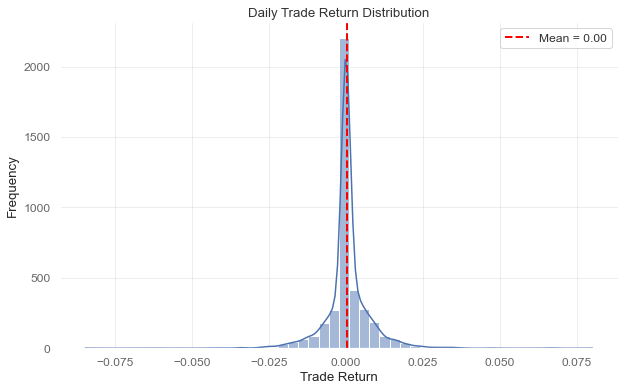

In [396]:
# 每日報酬直方圖
import seaborn as sns
plt.figure(figsize=(10,6))
sns.histplot(txf_df['TradeReturn'], bins=50, kde=True)

# 計算平均值
mean_return = txf_df['TradeReturn'].mean()

# 畫平均線
plt.axvline(mean_return, color='red', linestyle='--', linewidth=2, label=f'Mean = {mean_return:.2f}')

plt.title('Daily Trade Return Distribution')
plt.xlabel('Trade Return')
plt.ylabel('Frequency')
plt.legend()
plt.show()

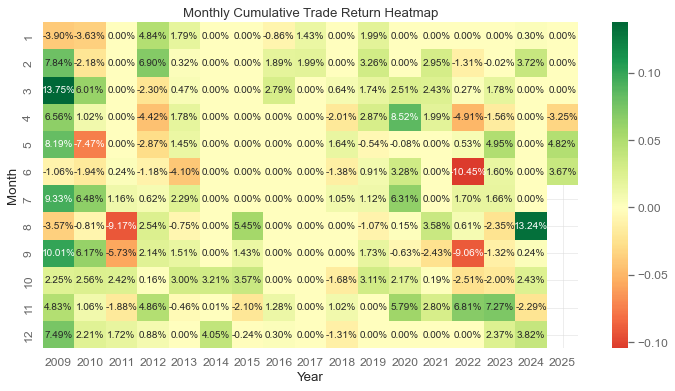

In [390]:
# 每月報酬熱力圖
monthly_return = txf_df.groupby(['Year','Month'])['TradeReturn'].sum().unstack(level=0)

plt.figure(figsize=(12,6))
sns.heatmap(monthly_return, annot=True, fmt=".2%", cmap="RdYlGn", center=0)
plt.title('Monthly Cumulative Trade Return Heatmap')
plt.xlabel('Year')
plt.ylabel('Month')
plt.show()


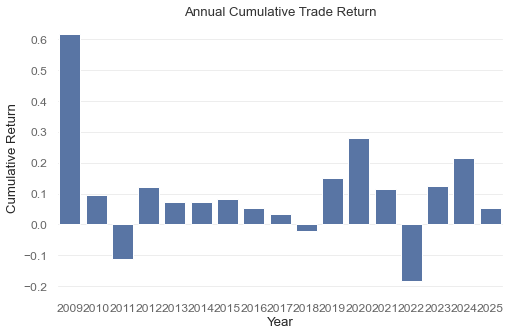

In [391]:
# 每年報酬直方圖
annual_return = txf_df.groupby('Year')['TradeReturn'].sum()

plt.figure(figsize=(8,5))
sns.barplot(x=annual_return.index, y=annual_return.values)
plt.title('Annual Cumulative Trade Return')
plt.xlabel('Year')
plt.ylabel('Cumulative Return')
plt.show()


In [392]:
# 計算策略單利累積報酬
txf_df['CumsumReturn'] = txf_df['TradeReturn'].cumsum()

market_df['Return'] = market_df['Close'].pct_change().shift(1)
market_df['SimpleReturn'] = market_df['Return'].cumsum()

# # 計算0050報酬 (買進手續費 0.1425% + 賣出交易稅 0.3% = 總一次性成本 ≈ 0.4425%)
# # 0050每年管理費率約 0.42% 每日費率約 0.42% / 252 = 0.0000166667
# df_0050['Return'] = (df_0050['Close'].pct_change().shift(1)) * (1 - 0.000035)
# df_0050['SimpleReturn'] = df_0050['Return'].cumsum()

In [393]:
import plotly.express as px
# trading_date(包含holing)
# 假設 txf_df['datetime'] 是 datetime 格式
trading_dates = txf_df.loc[txf_df['TradingDate'] == 1, 'datetime']
plot_df = pd.DataFrame({'TradingDay': trading_dates})

# 繪製互動式散點圖
fig = px.scatter(plot_df, x='TradingDay', y=[1] * len(trading_dates), 
                 title='Trading Days Timeline',
                 labels={'TradingDay': 'Date'},
                 hover_data={'TradingDay': True})
fig.update_yaxes(visible=False)  # 隱藏 Y 軸
fig.update_traces(marker=dict(size=10, symbol='line-ns-open'))
fig.show()

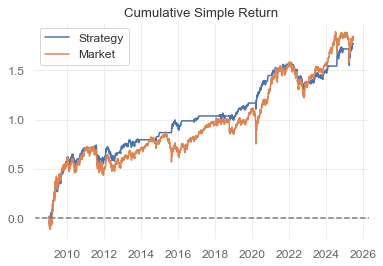

In [394]:
# 畫圖
plt.plot(txf_df['datetime'], txf_df['CumsumReturn'], label='Strategy')
plt.plot(market_df['datetime'], market_df['SimpleReturn'], label='Market')
plt.axhline(0, color='gray', linestyle='--')
plt.legend()
plt.title('Cumulative Simple Return')
plt.show()

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning:

The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning:

The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning:

The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)

c:\Users\herby\AppData\Local\Programs\Python\Python3

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2009-01-05  2009-01-05
End Period                 2025-06-27  2025-06-27
Risk-Free Rate             0.0%        0.0%
Time in Market             56.0%       100.0%

Cumulative Return          423.8%      369.97%
CAGR﹪                     10.57%      9.84%

Sharpe                     0.93        0.61
Prob. Sharpe Ratio         99.99%      99.22%
Smart Sharpe               0.9         0.59
Sortino                    1.37        0.85
Smart Sortino              1.34        0.83
Sortino/√2                 0.97        0.6
Smart Sortino/√2           0.94        0.58
Omega                      1.25        1.25

Max Drawdown               -25.67%     -31.51%
Longest DD Days            908         1217
Volatility (ann.)          11.92%      18.67%
R^2                        0.0         0.0
Information Ratio          -0.0        -0.0
Calmar                     0.41        

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2022-02-11,2022-10-25,2024-08-07,908,-25.672372,-24.512114
2,2011-07-28,2011-09-26,2013-04-30,642,-18.690394,-16.969816
3,2024-11-11,2025-04-09,2025-05-14,184,-17.623462,-11.442592
4,2010-04-16,2010-06-09,2010-09-13,150,-12.132905,-11.521972
5,2015-11-05,2016-01-21,2016-12-01,392,-10.013289,-9.262878


c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\quantstats\_plotting\core.py:293: UserWarning:

Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing from font(s) Arial.

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\quantstats\_plotting\core.py:293: UserWarning:

Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from font(s) Arial.

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\quantstats\_plotting\core.py:293: UserWarning:

Glyph 20845 (\N{CJK UNIFIED IDEOGRAPH-516D}) missing from font(s) Arial.

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing from font(s) Arial.

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from font(s) Arial.

c:\Users\herby\AppData\Local\

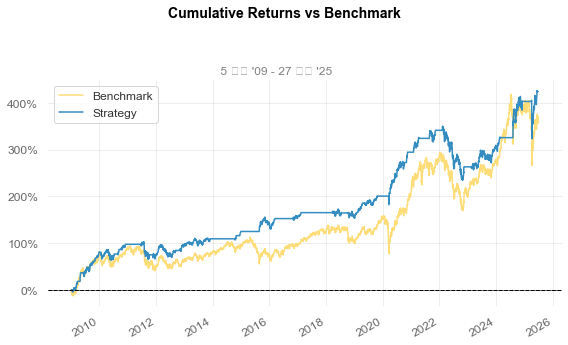

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\quantstats\_plotting\core.py:293: UserWarning:

Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing from font(s) Arial.

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\quantstats\_plotting\core.py:293: UserWarning:

Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from font(s) Arial.

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\quantstats\_plotting\core.py:293: UserWarning:

Glyph 20845 (\N{CJK UNIFIED IDEOGRAPH-516D}) missing from font(s) Arial.

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing from font(s) Arial.

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from font(s) Arial.

c:\Users\herby\AppData\Local\

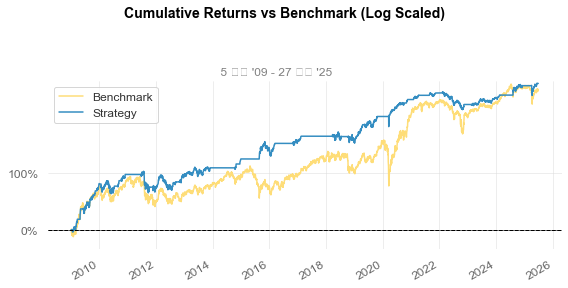

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\quantstats\_plotting\core.py:293: UserWarning:

Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing from font(s) Arial.

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\quantstats\_plotting\core.py:293: UserWarning:

Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from font(s) Arial.

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\quantstats\_plotting\core.py:293: UserWarning:

Glyph 20845 (\N{CJK UNIFIED IDEOGRAPH-516D}) missing from font(s) Arial.

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing from font(s) Arial.

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from font(s) Arial.

c:\Users\herby\AppData\Local\

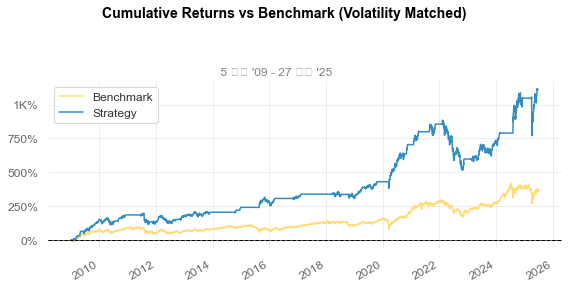

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\quantstats\_plotting\wrappers.py:376: FutureWarning:

'A' is deprecated and will be removed in a future version, please use 'YE' instead.

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\quantstats\_plotting\wrappers.py:377: FutureWarning:

'A' is deprecated and will be removed in a future version, please use 'YE' instead.

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\quantstats\_plotting\wrappers.py:383: FutureWarning:

'A' is deprecated and will be removed in a future version, please use 'YE' instead.

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\quantstats\_plotting\wrappers.py:386: FutureWarning:

'A' is deprecated and will be removed in a future version, please use 'YE' instead.



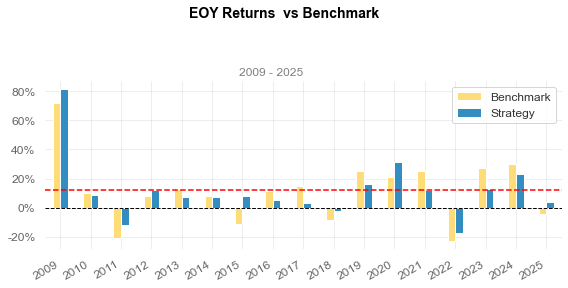

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\quantstats\_plotting\core.py:325: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\quantstats\_plotting\core.py:326: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



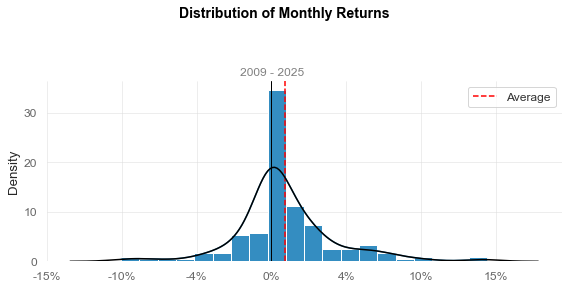

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\quantstats\_plotting\core.py:293: UserWarning:

Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing from font(s) Arial.

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\quantstats\_plotting\core.py:293: UserWarning:

Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from font(s) Arial.

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\quantstats\_plotting\core.py:293: UserWarning:

Glyph 20845 (\N{CJK UNIFIED IDEOGRAPH-516D}) missing from font(s) Arial.

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing from font(s) Arial.

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from font(s) Arial.

c:\Users\herby\AppData\Local\

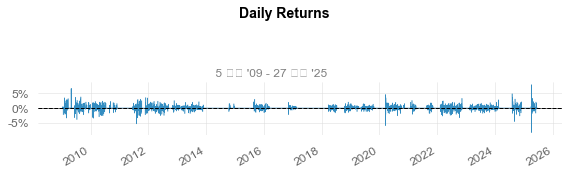

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\quantstats\_plotting\core.py:540: UserWarning:

Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing from font(s) Arial.

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\quantstats\_plotting\core.py:540: UserWarning:

Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from font(s) Arial.

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\quantstats\_plotting\core.py:540: UserWarning:

Glyph 20845 (\N{CJK UNIFIED IDEOGRAPH-516D}) missing from font(s) Arial.

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing from font(s) Arial.

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from font(s) Arial.

c:\Users\herby\AppData\Local\

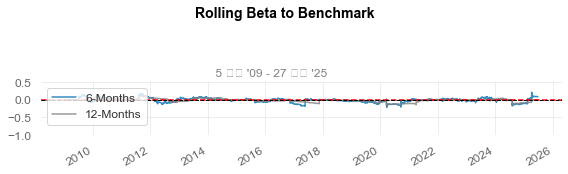

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\quantstats\_plotting\core.py:462: UserWarning:

Glyph 19971 (\N{CJK UNIFIED IDEOGRAPH-4E03}) missing from font(s) Arial.

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\quantstats\_plotting\core.py:462: UserWarning:

Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from font(s) Arial.

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\quantstats\_plotting\core.py:462: UserWarning:

Glyph 20845 (\N{CJK UNIFIED IDEOGRAPH-516D}) missing from font(s) Arial.

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 19971 (\N{CJK UNIFIED IDEOGRAPH-4E03}) missing from font(s) Arial.

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from font(s) Arial.

c:\Users\herby\AppData\Local\

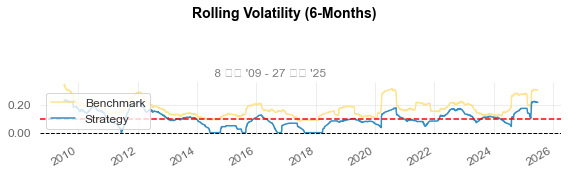

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\quantstats\_plotting\core.py:462: UserWarning:

Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing from font(s) Arial.

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\quantstats\_plotting\core.py:462: UserWarning:

Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from font(s) Arial.

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\quantstats\_plotting\core.py:462: UserWarning:

Glyph 20845 (\N{CJK UNIFIED IDEOGRAPH-516D}) missing from font(s) Arial.

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing from font(s) Arial.

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from font(s) Arial.

c:\Users\herby\AppData\Local\

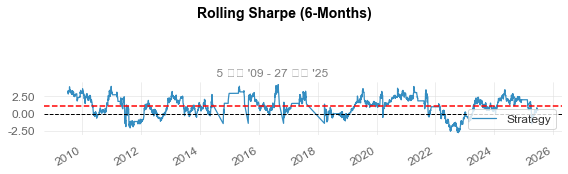

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\quantstats\_plotting\core.py:462: UserWarning:

Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing from font(s) Arial.

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\quantstats\_plotting\core.py:462: UserWarning:

Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from font(s) Arial.

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\quantstats\_plotting\core.py:462: UserWarning:

Glyph 20845 (\N{CJK UNIFIED IDEOGRAPH-516D}) missing from font(s) Arial.

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing from font(s) Arial.

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from font(s) Arial.

c:\Users\herby\AppData\Local\

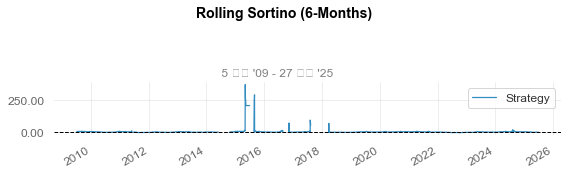

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\quantstats\_plotting\core.py:626: UserWarning:

Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing from font(s) Arial.

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\quantstats\_plotting\core.py:626: UserWarning:

Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from font(s) Arial.

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\quantstats\_plotting\core.py:626: UserWarning:

Glyph 20845 (\N{CJK UNIFIED IDEOGRAPH-516D}) missing from font(s) Arial.

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing from font(s) Arial.

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from font(s) Arial.

c:\Users\herby\AppData\Local\

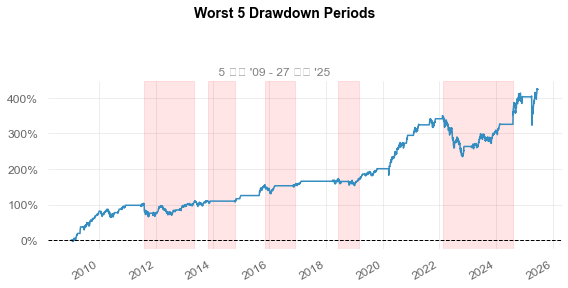

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\quantstats\_plotting\core.py:293: UserWarning:

Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing from font(s) Arial.

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\quantstats\_plotting\core.py:293: UserWarning:

Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from font(s) Arial.

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\quantstats\_plotting\core.py:293: UserWarning:

Glyph 20845 (\N{CJK UNIFIED IDEOGRAPH-516D}) missing from font(s) Arial.

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing from font(s) Arial.

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from font(s) Arial.

c:\Users\herby\AppData\Local\

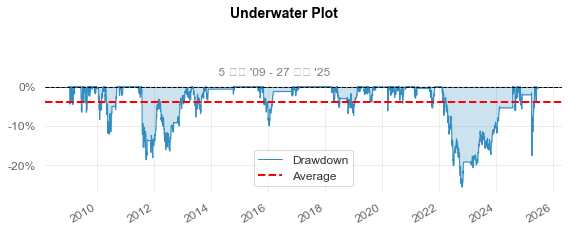

TypeError: DataFrame.pivot() takes 1 positional argument but 4 were given

In [395]:
strategy_returns = txf_df.set_index('datetime')["TradeReturn"]
benchmark = market_df.set_index('datetime')["Return"]
qs.reports.full(strategy_returns,benchmark=benchmark)